# TASK 3
##### forecast for non member = [4525.845543 ,8651.739222 ,10584.250167 ,4858.442004 ,4765.221393 ,5256.376506  ,5075.633098]
##### forecast fot member  = [19697.608414 ,15780.497133 ,17220.698246 ,24787.167032 ,22484.023725 ,25369.011824 ,23763.249126]

I haven't used brute force gridsearch or pmdarima as I believe that would defeat the purpose of the exercise
From experience, when determining the parameters via PACF/ACF its worth to check out parameters around the obvious ones. For example if the acf suggest MA = 1 it's worth to check how model behaves on 0 na 2 as well. I didn't go for that approach here too as it falls into 'guessing' category.

To evaluate quality of fit I didn't use metrics like AIC as I wasn't concern with complexity of the model. MSE was chosen as simple way to evaluate plus it allowed to account for cases when model didn't fit correctly on substential spikes (or produced big spike when there was't one.


There is uils clas ForecstMaker in help_utils module (sorry not the most clean code) and the source code with the approaches attended are below

Best approach is marked with (BEST)

In [1]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import warnings
import joblib
from datetime import datetime
from help_utils import ForecastMaker
warnings.filterwarnings('ignore')
%matplotlib inline

<AxesSubplot:xlabel='start_date'>

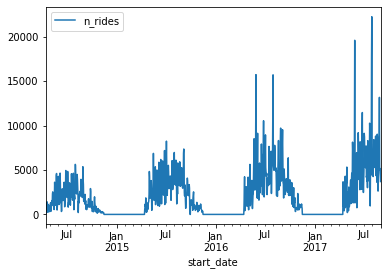

In [2]:
# couple of sharp spikes. posibly outliers. could be removed/smoothed (with rolling mean for example). 
# Kept as is at this stage removing data just bacause it doesn't look right may not be the best practice
fm = ForecastMaker()
df_non_member= fm.get_data_ex_three()
df_non_member.plot()

<AxesSubplot:xlabel='start_date'>

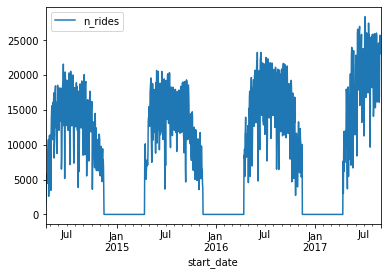

In [3]:
fm = ForecastMaker()
df_member= fm.get_data_ex_three(member = True)
df_member.plot()

Data is not stationary, p value is 0.6072147850473232
None


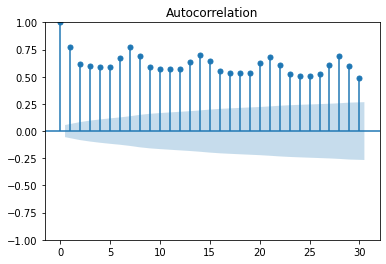

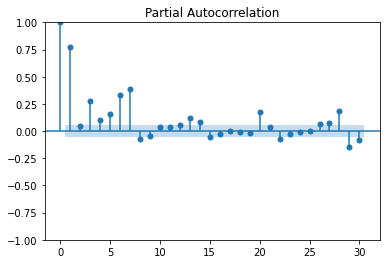

In [4]:
#weekly seasonality
plot_acf(df_non_member["n_rides"],lags=30);
plot_pacf(df_non_member,lags=30);
print (fm.is_stationary(df_non_member["n_rides"]))

Data is not stationary, p value is 0.38864540845304363
None


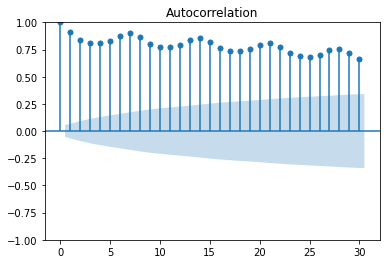

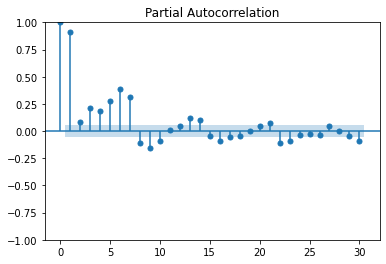

In [5]:
#weekly seasonality 
plot_acf(df_member["n_rides"],lags=30);
plot_pacf(df_member,lags=30);
print (fm.is_stationary(df_member["n_rides"]))

In [8]:
df_non_member["n_rides"] = df_non_member["n_rides"].diff()
df_non_member.dropna(inplace=True)
fm.is_stationary(df_non_member["n_rides"])


df_member["n_rides"] = df_member["n_rides"].diff()
df_member.dropna(inplace=True)
fm.is_stationary(df_member["n_rides"])

Data is stationary, p value is 3.3249447254300455e-19
Data is stationary, p value is 8.404536346529756e-11


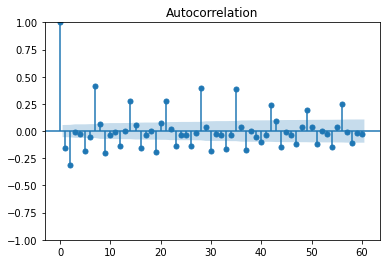

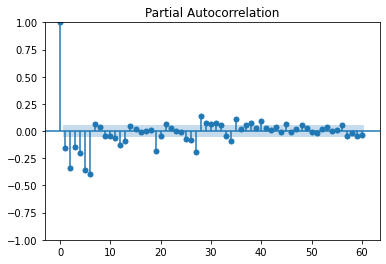

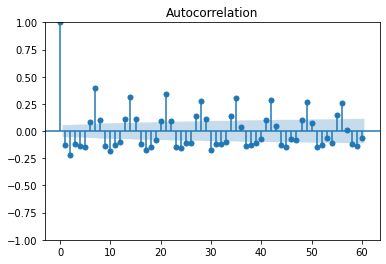

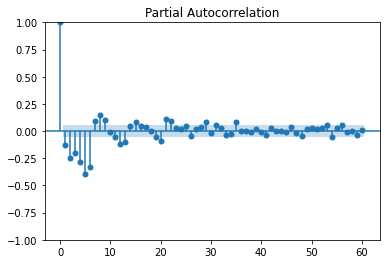

In [9]:
#checjing for lags' acf and pacf significance for non_member
# d = 1, since we differenced once only
# p = 1-7 
# q = 1,2 
plot_acf(df_non_member["n_rides"],lags=60);
plot_pacf(df_non_member,lags=60);




#checjing for lags' acf and pacf significance for member
#on pacf there is a bigger drop after 1 lag so probably better option but we can afford to check all the option
# d = 1, since we differenced once only
# p = 1-9
# q = 0,1,2 acf looks like a strong seasonality, there is a bit of drop after lag 2- option up to it
plot_acf(df_member["n_rides"],lags=60);
plot_pacf(df_member,lags=60);

# NON MEMBER FORECASTS

### Approach one (non member) PROVED TO FIT BEST
Use all combinations of the parameters picked to fit SARIMA and return one that shown best result on MSE versus test 

7
([1, 2, 3, 4, 5, 6, 7], [1], [1, 2], [0, 1], [0, 1], [0, 1], [7])
i ((1, 1, 1), (0, 0, 0, 7))
((1, 1, 1), (0, 0, 0, 7)) 7258098.911695107
i ((1, 1, 1), (0, 0, 1, 7))
((1, 1, 1), (0, 0, 1, 7)) 6500178.2723221565
i ((1, 1, 1), (0, 1, 0, 7))
((1, 1, 1), (0, 1, 0, 7)) 2932407.733889815
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (1, 0, 0, 7))
i ((1, 1, 1), (1, 0, 1, 7))
((1, 1, 1), (1, 0, 1, 7)) 2918203.649003857
i ((1, 1, 1), (1, 1, 0, 7))
((1, 1, 1), (1, 1, 0, 7)) 2867159.658111925
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 1, 7))
((1, 1, 2), (0, 1, 1, 7)) 2769874.8841117504
i ((1, 1, 2), (1, 0, 0, 7))
i ((1, 1, 2), (1, 0, 1, 7))
i ((1, 1, 2), (1, 1, 0, 7))
i ((1, 1, 2), (1, 1, 1, 7))
((1, 1, 2), (1, 1, 1, 7)) 2726464.200764662
i ((2, 1, 1), (0, 0, 0, 7))
i ((2, 1, 1), (0, 0, 1, 7))
i ((2, 1, 1), (0, 1, 0, 7))
i ((2, 1, 1), (0, 1, 1, 7))
i ((2, 1, 1), (1, 0, 0, 7))
i ((2, 1, 1), (1, 0, 1, 7))
i ((2,

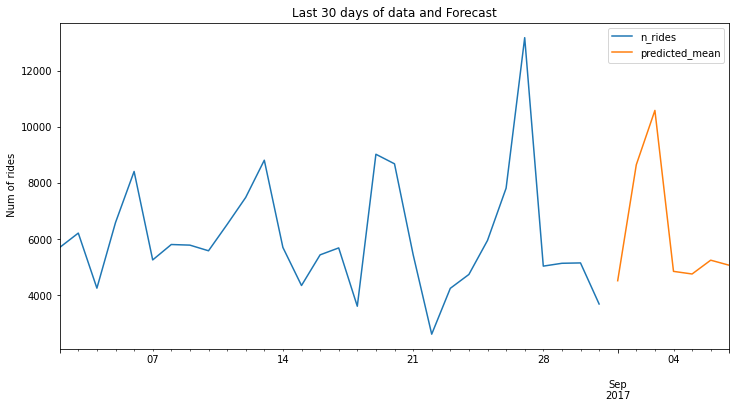

In [10]:
#all possible parameters
p = [i for i in range(1,8)]
d = [1]
q = [1,2]
P = [0,1]
D = [0,1]
Q = [0,1]
m = [7]
df_non_member= fm.get_data_ex_three()
best_rusults_non_memeber = fm.evaluate_and_return_best_forecast(SARIMAX, df_non_member, (p,d,q,P,D,Q,m),3)
fm.plot_forecast(df_non_member,best_rusults_non_memeber)

In [19]:
best_rusults_non_memeber

{'best_model': <statsmodels.tsa.statespace.sarimax.SARIMAX at 0x191003c04c0>,
 'best_mse': 2152511.798059462,
 'best_forecast': 2017-09-01     4525.845543
 2017-09-02     8651.739222
 2017-09-03    10584.250167
 2017-09-04     4858.442004
 2017-09-05     4765.221393
 2017-09-06     5256.376506
 2017-09-07     5075.633098
 Name: predicted_mean, dtype: float64}

### Approach two (non member)

same logic as in task two - providing month as exog feature 

7
([1, 2, 3, 4, 5, 6, 7], [1], [1, 2], [0, 1], [0, 1], [0, 1], [7])
i ((1, 1, 1), (0, 0, 0, 7))
((1, 1, 1), (0, 0, 0, 7)) 7256524.5628349045
i ((1, 1, 1), (0, 0, 1, 7))
((1, 1, 1), (0, 0, 1, 7)) 6498973.774813684
i ((1, 1, 1), (0, 1, 0, 7))
((1, 1, 1), (0, 1, 0, 7)) 2932478.026074453
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (1, 0, 0, 7))
i ((1, 1, 1), (1, 0, 1, 7))
((1, 1, 1), (1, 0, 1, 7)) 2927677.1602089824
i ((1, 1, 1), (1, 1, 0, 7))
((1, 1, 1), (1, 1, 0, 7)) 2867282.7596523627
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 1, 7))
((1, 1, 2), (0, 1, 1, 7)) 2783358.3879903336
i ((1, 1, 2), (1, 0, 0, 7))
i ((1, 1, 2), (1, 0, 1, 7))
i ((1, 1, 2), (1, 1, 0, 7))
i ((1, 1, 2), (1, 1, 1, 7))
((1, 1, 2), (1, 1, 1, 7)) 2736944.089780332
i ((2, 1, 1), (0, 0, 0, 7))
i ((2, 1, 1), (0, 0, 1, 7))
i ((2, 1, 1), (0, 1, 0, 7))
i ((2, 1, 1), (0, 1, 1, 7))
i ((2, 1, 1), (1, 0, 0, 7))
i ((2, 1, 1), (1, 0, 1, 7))
i ((

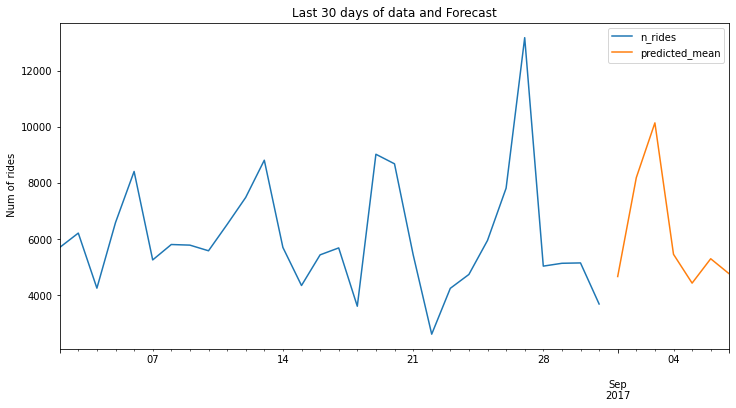

In [11]:
df_non_member= fm.get_data_ex_three()
months = df_non_member.index.month
best_rusults_non_member_exog = fm.evaluate_and_return_best_forecast(SARIMAX, df_non_member, (p,d,q,P,D,Q,m), 3, exog = months)
fm.plot_forecast(df_non_member,best_rusults_non_member_exog)

### Approach three (non member)

same logic as in task two - trim data to August and September

7
([1, 2, 3, 4, 5, 6, 7], [1], [1, 2], [0, 1], [0, 1], [0, 1], [7, 61])
i ((1, 1, 1), (0, 0, 0, 7))
((1, 1, 1), (0, 0, 0, 7)) 8132472.234273429
i ((1, 1, 1), (0, 0, 0, 61))
i ((1, 1, 1), (0, 0, 1, 7))
((1, 1, 1), (0, 0, 1, 7)) 7793239.946320584
i ((1, 1, 1), (0, 0, 1, 61))
((1, 1, 1), (0, 0, 1, 61)) 6837392.362734051
i ((1, 1, 1), (0, 1, 0, 7))
((1, 1, 1), (0, 1, 0, 7)) 2982821.5844060206
i ((1, 1, 1), (0, 1, 0, 61))
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (0, 1, 1, 61))
i ((1, 1, 1), (1, 0, 0, 7))
i ((1, 1, 1), (1, 0, 0, 61))
i ((1, 1, 1), (1, 0, 1, 7))
i ((1, 1, 1), (1, 0, 1, 61))
i ((1, 1, 1), (1, 1, 0, 7))
((1, 1, 1), (1, 1, 0, 7)) 2940075.2551435656
i ((1, 1, 1), (1, 1, 0, 61))
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 1), (1, 1, 1, 61))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 0, 61))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 0, 1, 61))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 0, 61))
i ((1, 1, 2), (0, 1, 1, 7))
i ((1, 1, 2), (0, 1, 1, 61))
i ((1, 1, 2), (1, 0, 

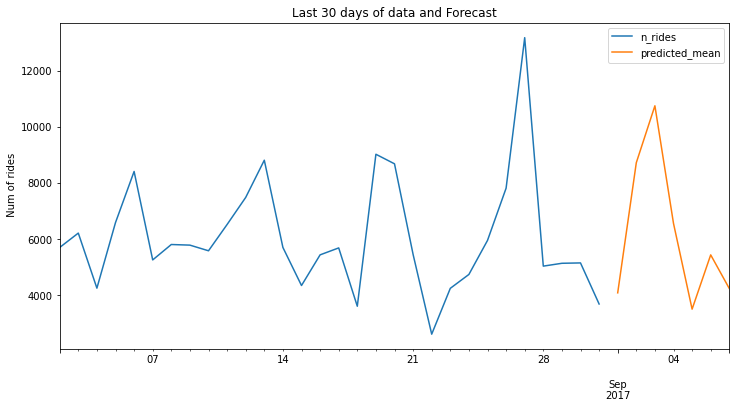

In [12]:
m = [7,61] # 61 is redundand, it never results in better model
df_non_member_special= fm.get_data_ex_three(special=True)
best_rusults_non_member_sp = fm.evaluate_and_return_best_forecast(SARIMAX, df_non_member_special, (p,d,q,P,D,Q,m), 3)
fm.plot_forecast(df_non_member_special,best_rusults_non_member_sp)

### Approach four (non member)

same logic as in task two - trim data to August and September provide months feature as exog 

7
([1, 2, 3, 4, 5, 6, 7], [1], [1, 2], [0, 1], [0, 1], [0, 1], [7])
i ((1, 1, 1), (0, 0, 0, 7))
((1, 1, 1), (0, 0, 0, 7)) 7442303.065970488
i ((1, 1, 1), (0, 0, 1, 7))
((1, 1, 1), (0, 0, 1, 7)) 7019544.930246589
i ((1, 1, 1), (0, 1, 0, 7))
((1, 1, 1), (0, 1, 0, 7)) 3157547.6660009273
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (1, 0, 0, 7))
i ((1, 1, 1), (1, 0, 1, 7))
i ((1, 1, 1), (1, 1, 0, 7))
((1, 1, 1), (1, 1, 0, 7)) 2986812.537018052
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 1, 7))
i ((1, 1, 2), (1, 0, 0, 7))
i ((1, 1, 2), (1, 0, 1, 7))
i ((1, 1, 2), (1, 1, 0, 7))
i ((1, 1, 2), (1, 1, 1, 7))
i ((2, 1, 1), (0, 0, 0, 7))
i ((2, 1, 1), (0, 0, 1, 7))
i ((2, 1, 1), (0, 1, 0, 7))
i ((2, 1, 1), (0, 1, 1, 7))
i ((2, 1, 1), (1, 0, 0, 7))
i ((2, 1, 1), (1, 0, 1, 7))
i ((2, 1, 1), (1, 1, 0, 7))
i ((2, 1, 1), (1, 1, 1, 7))
i ((2, 1, 2), (0, 0, 0, 7))
i ((2, 1, 2), (0, 0, 1, 7))
i ((2, 1, 2), (0, 1, 0, 7))

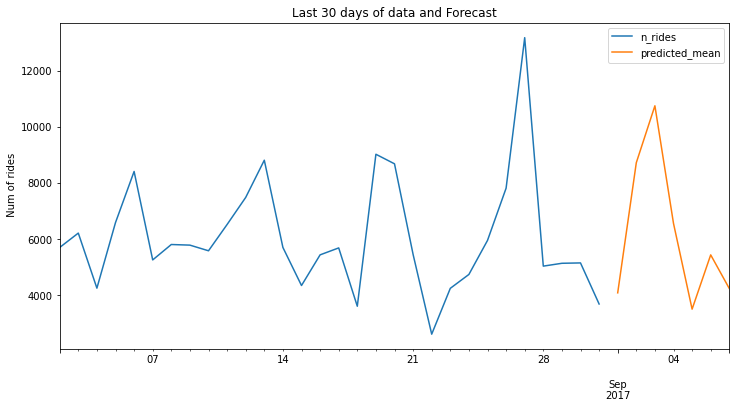

In [14]:
m = [7]
df_non_member_special= fm.get_data_ex_three(special=True)
months = df_non_member_special.index.month
best_rusults_non_member_sp_ex = fm.evaluate_and_return_best_forecast(SARIMAX, df_non_member_special, (p,d,q,P,D,Q,m), 3, exog=months)
fm.plot_forecast(df_non_member_special,best_rusults_non_member_sp_ex)

# MEMBER FORECAST
#### following same exact approaches as NON MEMBER

### Approach one (member)
Use all combinations of the parameters picked to fit SARIMA and return one that shown best result on MSE versus test 

7
([1, 2, 3, 4, 5, 6, 7, 8, 9], [1], [0, 1, 2], [0, 1], [0, 1], [0, 1], [7])
i ((1, 1, 0), (0, 0, 0, 7))
((1, 1, 0), (0, 0, 0, 7)) 34343994.189629294
i ((1, 1, 0), (0, 0, 1, 7))
((1, 1, 0), (0, 0, 1, 7)) 29426257.754018046
i ((1, 1, 0), (0, 1, 0, 7))
((1, 1, 0), (0, 1, 0, 7)) 8794479.305409394
i ((1, 1, 0), (0, 1, 1, 7))
((1, 1, 0), (0, 1, 1, 7)) 7729144.199518959
i ((1, 1, 0), (1, 0, 0, 7))
i ((1, 1, 0), (1, 0, 1, 7))
i ((1, 1, 0), (1, 1, 0, 7))
((1, 1, 0), (1, 1, 0, 7)) 6325127.635085435
i ((1, 1, 0), (1, 1, 1, 7))
i ((1, 1, 1), (0, 0, 0, 7))
i ((1, 1, 1), (0, 0, 1, 7))
i ((1, 1, 1), (0, 1, 0, 7))
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (1, 0, 0, 7))
i ((1, 1, 1), (1, 0, 1, 7))
i ((1, 1, 1), (1, 1, 0, 7))
((1, 1, 1), (1, 1, 0, 7)) 6267818.8330041515
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 1, 7))
i ((1, 1, 2), (1, 0, 0, 7))
i ((1, 1, 2), (1, 0, 1, 7))
i ((1, 1, 2), (1, 1, 0, 7))
i ((1, 1, 2)

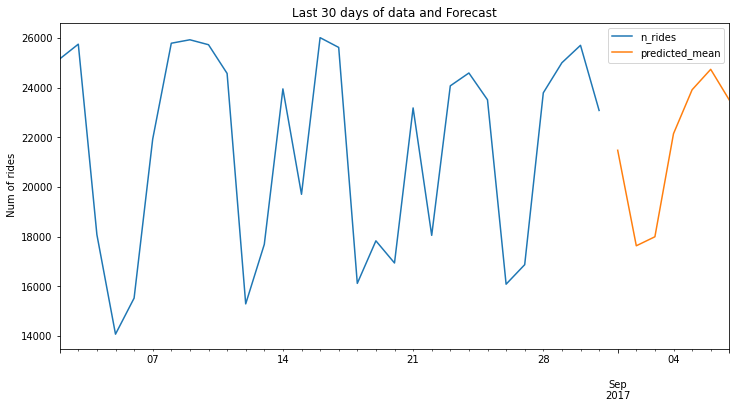

In [15]:
#all possible parameters
p = [i for i in range(1,10)]
d = [1]
q = [0,1,2]
P = [0,1]
D = [0,1]
Q = [0,1]
m = [7]
df_member= fm.get_data_ex_three(member=True)
best_rusults_memeber = fm.evaluate_and_return_best_forecast(SARIMAX, df_member, (p,d,q,P,D,Q,m),3)
fm.plot_forecast(df_member,best_rusults_memeber)

### Approach two (member)

same logic as in task two - providing month as exog feature 

7
([1, 2, 3, 4, 5, 6, 7, 8, 9], [1], [0, 1, 2], [0, 1], [0, 1], [0, 1], [7])
i ((1, 1, 0), (0, 0, 0, 7))
((1, 1, 0), (0, 0, 0, 7)) 34343564.643664636
i ((1, 1, 0), (0, 0, 1, 7))
((1, 1, 0), (0, 0, 1, 7)) 29440131.748567633
i ((1, 1, 0), (0, 1, 0, 7))
((1, 1, 0), (0, 1, 0, 7)) 8794475.845894452
i ((1, 1, 0), (0, 1, 1, 7))
((1, 1, 0), (0, 1, 1, 7)) 7741716.092491944
i ((1, 1, 0), (1, 0, 0, 7))
i ((1, 1, 0), (1, 0, 1, 7))
i ((1, 1, 0), (1, 1, 0, 7))
((1, 1, 0), (1, 1, 0, 7)) 6325008.438798694
i ((1, 1, 0), (1, 1, 1, 7))
i ((1, 1, 1), (0, 0, 0, 7))
i ((1, 1, 1), (0, 0, 1, 7))
i ((1, 1, 1), (0, 1, 0, 7))
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (1, 0, 0, 7))
i ((1, 1, 1), (1, 0, 1, 7))
i ((1, 1, 1), (1, 1, 0, 7))
((1, 1, 1), (1, 1, 0, 7)) 6274208.786846147
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 1, 7))
i ((1, 1, 2), (1, 0, 0, 7))
i ((1, 1, 2), (1, 0, 1, 7))
i ((1, 1, 2), (1, 1, 0, 7))
i ((1, 1, 2),

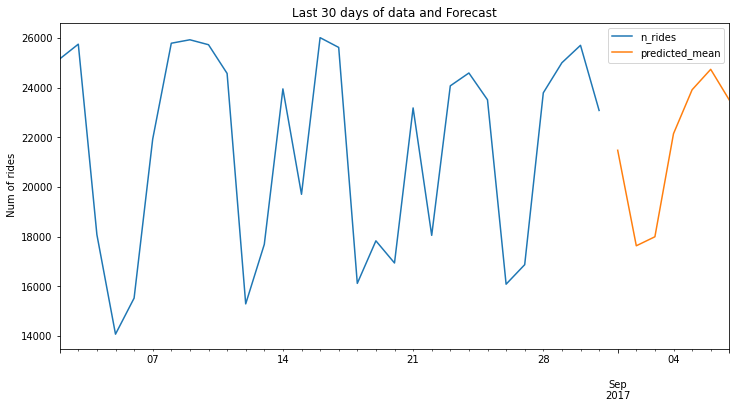

In [16]:
df_member= fm.get_data_ex_three(member=True)
months = df_member.index.month
best_rusults_member_exog = fm.evaluate_and_return_best_forecast(SARIMAX, df_member, (p,d,q,P,D,Q,m), 3, exog = months)
fm.plot_forecast(df_member,best_rusults_member_exog)

### Approach three (member) PROVED TO FIT BEST

same logic as in task two - trim data to August and September

7
([1, 2, 3, 4, 5, 6, 7, 8, 9], [1], [0, 1, 2], [0, 1], [0, 1], [0, 1], [7])
i ((1, 1, 0), (0, 0, 0, 7))
((1, 1, 0), (0, 0, 0, 7)) 34210442.24848387
i ((1, 1, 0), (0, 0, 1, 7))
((1, 1, 0), (0, 0, 1, 7)) 31837948.43804296
i ((1, 1, 0), (0, 1, 0, 7))
((1, 1, 0), (0, 1, 0, 7)) 8764341.461032623
i ((1, 1, 0), (0, 1, 1, 7))
i ((1, 1, 0), (1, 0, 0, 7))
i ((1, 1, 0), (1, 0, 1, 7))
i ((1, 1, 0), (1, 1, 0, 7))
((1, 1, 0), (1, 1, 0, 7)) 6427201.063397
i ((1, 1, 0), (1, 1, 1, 7))
i ((1, 1, 1), (0, 0, 0, 7))
i ((1, 1, 1), (0, 0, 1, 7))
i ((1, 1, 1), (0, 1, 0, 7))
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (1, 0, 0, 7))
i ((1, 1, 1), (1, 0, 1, 7))
i ((1, 1, 1), (1, 1, 0, 7))
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 1, 7))
((1, 1, 2), (0, 1, 1, 7)) 5975450.03284471
i ((1, 1, 2), (1, 0, 0, 7))
i ((1, 1, 2), (1, 0, 1, 7))
i ((1, 1, 2), (1, 1, 0, 7))
i ((1, 1, 2), (1, 1, 1, 7))
i ((2, 1, 0), (0, 0, 0, 7))
i ((2, 

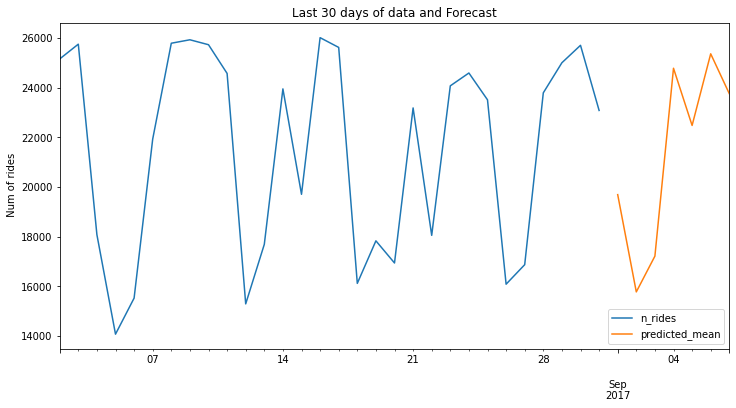

In [17]:
m = [7]
df_member_special= fm.get_data_ex_three(special=True, member=True)
best_rusults_member_sp = fm.evaluate_and_return_best_forecast(SARIMAX, df_member_special, (p,d,q,P,D,Q,m), 3)
fm.plot_forecast(df_member_special,best_rusults_member_sp)

In [20]:
best_rusults_member_sp

{'best_model': <statsmodels.tsa.statespace.sarimax.SARIMAX at 0x1910773ea60>,
 'best_mse': 4880520.23242639,
 'best_forecast': 2017-09-01    19697.608414
 2017-09-02    15780.497133
 2017-09-03    17220.698246
 2017-09-04    24787.167032
 2017-09-05    22484.023725
 2017-09-06    25369.011824
 2017-09-07    23763.249126
 Name: predicted_mean, dtype: float64}

### Approach four (member)

same logic as in task two - trim data to August and September provide months feature as exog 

7
([1, 2, 3, 4, 5, 6, 7, 8, 9], [1], [0, 1, 2], [0, 1], [0, 1], [0, 1], [7])
i ((1, 1, 0), (0, 0, 0, 7))
((1, 1, 0), (0, 0, 0, 7)) 34212835.52015165
i ((1, 1, 0), (0, 0, 1, 7))
((1, 1, 0), (0, 0, 1, 7)) 30904193.265823875
i ((1, 1, 0), (0, 1, 0, 7))
((1, 1, 0), (0, 1, 0, 7)) 8756956.705291595
i ((1, 1, 0), (0, 1, 1, 7))
((1, 1, 0), (0, 1, 1, 7)) 8719454.67230482
i ((1, 1, 0), (1, 0, 0, 7))
i ((1, 1, 0), (1, 0, 1, 7))
i ((1, 1, 0), (1, 1, 0, 7))
((1, 1, 0), (1, 1, 0, 7)) 6605457.736576987
i ((1, 1, 0), (1, 1, 1, 7))
i ((1, 1, 1), (0, 0, 0, 7))
i ((1, 1, 1), (0, 0, 1, 7))
i ((1, 1, 1), (0, 1, 0, 7))
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (1, 0, 0, 7))
i ((1, 1, 1), (1, 0, 1, 7))
i ((1, 1, 1), (1, 1, 0, 7))
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 1, 7))
i ((1, 1, 2), (1, 0, 0, 7))
i ((1, 1, 2), (1, 0, 1, 7))
i ((1, 1, 2), (1, 1, 0, 7))
((1, 1, 2), (1, 1, 0, 7)) 6489283.375298267
i ((1, 1, 2), (

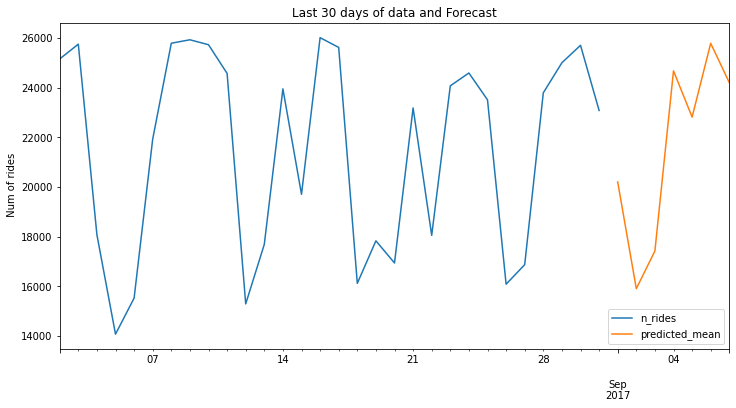

In [18]:
df_member_special= fm.get_data_ex_three(special=True, member=True)
months = df_member_special.index.month
best_rusults_member_sp_ex = fm.evaluate_and_return_best_forecast(SARIMAX, df_member_special, (p,d,q,P,D,Q,m), 3, exog=months)
fm.plot_forecast(df_member_special,best_rusults_member_sp_ex)